In [1]:
%cd ..

/mnt/c/Users/XCB/OneDrive - Van Oord/Documents/thesis/code


In [2]:
from atl_module import kriging
import geopandas as gpd
from atl_module import GebcoUpscaler
import rasterio as rio
from shapely.geometry import box

In [3]:
jarkuspts = gpd.read_file("../data/jarkus/jarkus-2021_Noord-Holland.gpkg")

In [4]:
jarkuspts = jarkuspts.assign(X=jarkuspts.geometry.x, Y=jarkuspts.geometry.y)

In [5]:
truth = rio.open("../data/special_sites/petten/in-situ-DEM/truth.vrt")
truthrascrs = truth.crs
truth_ras_bounds = truth.bounds

In [6]:
subset_jarkus = (
    jarkuspts.to_crs(truthrascrs)
    .clip(truth_ras_bounds)
    .to_crs(jarkuspts.estimate_utm_crs())
)
# add the location in local UTM system as a columns
subset_jarkus = subset_jarkus.assign(
    northing=subset_jarkus.geometry.y,
    easting=subset_jarkus.geometry.x,
    sf_elev_MSL=subset_jarkus.geometry.z,
).loc[:, ["X", "Y", "northing", "easting", "sf_elev_MSL", "geometry"]]
sub_jarkus = subset_jarkus[subset_jarkus.sf_elev_MSL < 1]

TypeError: 'mask' should be GeoDataFrame, GeoSeries or(Multi)Polygon, got <class 'rasterio.coords.BoundingBox'>

In [ ]:
subset_jarkus.to_file("../data/special_sites/petten/all_bathy_pts.gpkg")

In [7]:
site = GebcoUpscaler(
    "../data/special_sites/petten",
    "Petten",
    "../data/special_sites/petten/in-situ-DEM/truth.vrt",
)

In [8]:
site.subset_gebco(50)

[D 220928 17:58:00 raster_interaction:149] GEBCO subset raster written to ../data/special_sites/petten/bilinear.tif, with CRS EPSG:32631


In [9]:
%%time
site.kriging(
    kr_model="uk",
    npts=2000,
    variogram_parameters={"range": 10000, "nugget": 0.7, "sill": 23},
    samplemethod="dart",
)

[I 220928 17:58:05 core:196] Kriging Petten site using 2000 points with crs epsg:32631 with options {'variogram_parameters': {'range': 10000, 'nugget': 0.7, 'sill': 23}, 'samplemethod': 'dart'}
[D 220928 17:58:06 kriging:29] The types of the numpy array that is sent to PDAL poisson dart throwing are: (numpy.record, [('Y', '<f8'), ('X', '<f8'), ('Z', '<f8')])
[D 220928 17:58:06 kriging:35] 2000 points remaining after relaxation dart throwing culling
/home/mlinds/mambaforge/envs/thesis_env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
[D 220928 17:58:06 kriging:79] 2000 points selected with dart written to ../data/special_sites/petten/kriging_pts


Adjusting data for anisotropy...
Initializing variogram model...
Using 'spherical' Variogram Model
Partial Sill: 22.3
Full Sill: 23.0
Range: 10000
Nugget: 0.7 

Calculating statistics on variogram model fit...
Q1 = 0.05330746775934529
Q2 = 4.354712439335329
cR = 5.427811804628765 

Initializing drift terms...
Executing Universal Kriging...



[D 220928 18:03:12 kriging:134] finished kriging, now saving the output raster to ../data/special_sites/petten/kriging_output.tif
[D 220928 18:03:12 kriging:152] Output raster of kriged Z values and uncertainty saved sucessfully


CPU times: user 40min 57s, sys: 33min 4s, total: 1h 14min 2s
Wall time: 5min 7s


In [10]:
site.kalman_update(1.5)
site.raster_rmse(check_kriged=True)

[I 220928 18:03:12 kalman:72] Wrote Kalman Updated Raster with GEBCO uncertainty 1.5 to ../data/special_sites/petten/kalman_updated.tif
[I 220928 18:03:12 core:229] Sucessful Kalman update of GEBCO bathymetry for Petten using a gebco standard deviation of 1.5 saved to ../data/special_sites/petten/kalman_updated.tif
/mnt/c/Users/XCB/OneDrive - Van Oord/Documents/thesis/code/atl_module/error_calc.py:172: RuntimeWarning: Mean of empty slice
  mse = np.nanmean(error_data**2)
/mnt/c/Users/XCB/OneDrive - Van Oord/Documents/thesis/code/atl_module/error_calc.py:174: RuntimeWarning: Mean of empty slice
  mae = np.nanmean(np.abs(error_data))
[I 220928 18:04:24 core:298] site:Petten - {"RMSE":{"Naive Bilinear Interpolation":1.4757187466,"Kalman Updated Raster":1.0270230913,"Kriged Raster":1.2916240326},"MAE":{"Naive Bilinear Interpolation":1.3139332533,"Kalman Updated Raster":0.7696832418,"Kriged Raster":0.7243122458}}


,RMSE,MAE
Naive Bilinear Interpolation,1.475719,1.313933
Kalman Updated Raster,1.027023,0.769683
Kriged Raster,1.291624,0.724312


In [11]:
site.bathy_pts_gdf = site.bathy_pts_gdf.assign(easting_corr=0, northing_corr=0)
site.add_truth_data()

[I 220928 18:05:01 core:257] Truth data added to Bathymetric Points dataframe for site: Petten


In [12]:
site.lidar_error()

[I 220928 18:05:01 core:238] Petten: RMSE between icesat and truth 0.46928823888558663, MAE: 0.29491203201446353


,MAE,RMSE,Median Abs error,R2 Score,Average Error
Petten,0.294912,0.469288,0.145,0.995713,-0.038357


[I 220928 18:05:02 core:340] Petten: Saved lidar error plot to ../document/figures/Petten_lidar_estimated_vs_truth.pdf


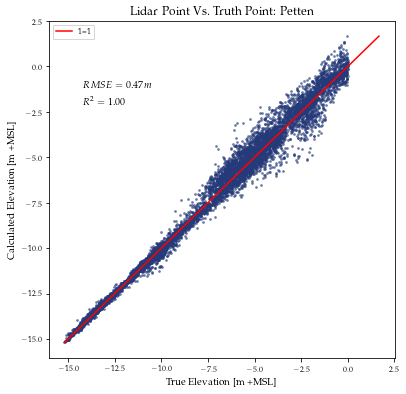

In [13]:
site.bathy_pts_gdf = site.bathy_pts_gdf[site.bathy_pts_gdf.true_elevation < 0]
site.plot_lidar_error()